# Подбор параметров nucleus-самплинга, с которыми вероятнее всего получение правильного следующего токена



In [21]:
import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead
import pandas as pd
import json
from tqdm import tqdm
from typing import List
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import wordpunct_tokenize
import re
from statistics import mean
from copy import copy
from tqdm import tqdm
tqdm.pandas()

In [4]:
from google.colab import drive

In [8]:
drive.mount('gdrive')

Mounted at gdrive


In [6]:
TEST_DF_PATH = 'gdrive/MyDrive/test_prompts.csv'

In [9]:
test_df = pd.read_csv(TEST_DF_PATH)

In [ ]:
for column in ['title_ner', 'text_ner', 'selected_entities']:
    test_df[column] = test_df[column].apply(json.loads)

In [ ]:
SELECTED_ENTITIES = ['PER', 'ORG']

BOS_TAG = 'BOS'
EOS_TAG = 'EOS'
TITLE_TAG = 'TITLE'
TEXT_TAG = 'TEXT'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
TOKENIZER_PATH = 'sberbank-ai/rugpt3small_based_on_gpt2'
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
tokenizer.add_special_tokens({'bos_token':BOS_TAG,
                              'eos_token':EOS_TAG,
                              'pad_token': '[PAD]',
                              'additional_special_tokens':[TITLE_TAG, TEXT_TAG, *SELECTED_ENTITIES]})


Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


7

In [ ]:
MODEL_PATH = 'gdrive/MyDrive/gpt_small_president_letter'
gpt = AutoModelWithLMHead.from_pretrained(MODEL_PATH).to(device).eval()

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Лучшие параметры самплинга для конкретного случая - такие, когда правильный токен последний из рассматриваемых (если ограничения более строгие, он никогда не будет выбран, если менее строгие - он может быть выбран, но с меньшей вероятностью)

In [ ]:
# функция была откуда-то скопирована, но давно и не мной, не помню источник и поэтому не могу сослаться
def best_k_p(logits:torch.tensor, golden:torch.tensor):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    ks = (sorted_indices == golden).nonzero()[:, 1]
    ps = cumulative_probs[sorted_indices == golden]
    return ks, ps

ToDo: вместо использования batch_size=1 написать учет падингов 

In [ ]:
all_best_ks, all_best_ps = [], []

for prompt in tqdm(list(test_df['prompt'])):
    encoding = tokenizer([prompt], return_tensors='pt').to(gpt.device)
    input_ids = encoding['input_ids']
    with torch.no_grad():
         logits = gpt(**encoding).logits
    # считаем параметры для всех токенов, кроме нулевого
    for token_idx in range(input_ids.shape[-1]-1):
        # по логиту предыдущего токена нужно с наивысшим качеством предсказывать следующий
        logit = logits[:, token_idx, :]
        gold = input_ids[:, token_idx+1]
        current_best_k, current_best_p = best_k_p(logit, gold)
        all_best_ks.append(current_best_k.item())
        all_best_ps.append(current_best_p.item())
    

100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


In [ ]:
pd.Series(all_best_ks).describe()

count    34088.000000
mean        36.104494
std        376.503023
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      25915.000000
dtype: float64

In [ ]:
pd.Series(all_best_ps).describe()

count    34088.000000
mean         0.922318
std          0.145132
min          0.115349
25%          0.922961
50%          0.993392
75%          0.999726
max          1.000008
dtype: float64

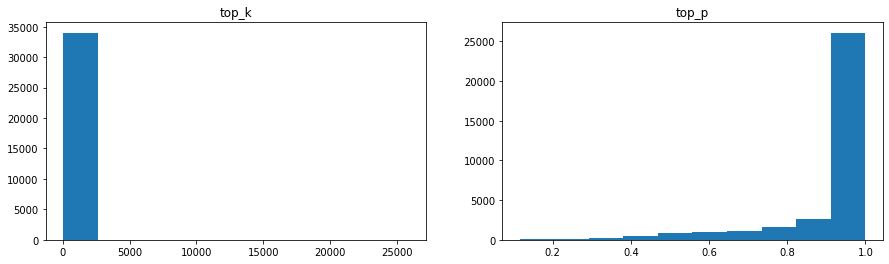

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 4]

plt.subplot(1, 2, 1)
plt.hist(all_best_ks)
plt.title('top_k')
plt.subplot(1, 2, 2)
plt.hist(all_best_ps)
plt.title('top_p')
plt.show()

Судя по распределению лучших top_k, лучшие параметры nucleus-самплинга близки к жадной генерации. То, что значения выше 0 наблюдаются только на 75-м перцентиле, подозрительно, но может быть связано с тем, что 

Если затравка генерации включает в себя фрагменты текста, которые нужно повторить, это ожидаемо.


# Генерация с разными параметрами

Сгенерирую тексты разными способами: жадно генерацией, beam search, nucleus_sampling с разными параметрами

In [ ]:
universal_parameters = {
    'min_length': 50,
    'max_length':250,
    # не позволяет модели генерировать падинги перед текстом и генерировать текст, реальная длина которого меньше заданной
    'bad_words_ids':[[tokenizer.pad_token_id]],
    'eos_token_id':tokenizer.eos_token_id,
    # параметр нужен исключительно чтобы избежать большого количества логов "Setting `pad_token_id` to `eos_token_id`"
    'pad_token_id':tokenizer.eos_token_id
}


In [16]:
method2generation_parameters = {
    'greedy':{},
    'beam_search_5beams': {'num_beams':5},
    'top_p_0.97': {'do_sample':True, 'top_p': 0.97},
    'top_p_0.9': {'do_sample':True, 'top_p':0.9},
    'top_k_3': {'do_sample':True, 'top_k':3},
    'top_k_15':{'do_sample':True, 'top_k':15},
    'top_p_0.9_temp2': {'do_sample':True, 'top_p':0.9, 'temperature':2.0},
    'top_k_15_temp2':{'do_sample':True, 'top_k':15, 'temperature':2.0}
}

In [ ]:
def generate(prompt, generation_method):
    if generation_method not in method2generation_parameters:
        raise ValueError('unknown generation method')
    input = tokenizer([prompt], return_tensors='pt').to(gpt.device)
    input.update(universal_parameters)
    input.update(method2generation_parameters[generation_method])
    output = gpt.generate(**input)
    return tokenizer.decode(output[0].tolist())

In [ ]:
def get_input_text(correct_formatted_text, separator_tag=TITLE_TAG):
   return correct_formatted_text.split(separator_tag)[0]+separator_tag

In [ ]:
test_df['prompt_beginning'] = test_df['prompt'].apply(get_input_text)

In [ ]:
for column in ['title_ner', 'text_ner', 'selected_entities']:
    test_df[column] = test_df[column].apply(json.dumps)

In [ ]:
for method in method2generation_parameters:
    print(method)
    test_df[method] = test_df['prompt_beginning'].progress_apply(lambda x: generate(x, method))
    test_df.to_csv(TEST_DF_PATH, index=False)

In [10]:
for column in ['title_ner', 'text_ner', 'selected_entities']:
    test_df[column] = test_df[column].apply(json.loads)

In [17]:
for method in method2generation_parameters:
    print(method)
    print(test_df[method].loc[0])
    print('________')

greedy
BOS PER Сергея Крамаренко ORG Вооружённых Сил TITLE Родным и близким Сергея Крамаренко TEXT Примите глубокие соболезнования в связи с кончиной Сергея Леонидовича Крамаренко. Сергей Леонидович был опытным руководителем, честным, порядочным, очень отзывчивым и доброжелательным человеком. Все, кто знал Сергея Леонидовича, ценили его за высокую компетентность, силу воли и мужество, честность и порядочность, верность своим принципам и долгу. Светлая память о Сергее Леонидовиче Крамаренко навсегда сохранится в сердцах близких, коллег, друзей. EOS
________
beam_search_5beams
BOS PER Сергея Крамаренко ORG Вооружённых Сил TITLE Родным и близким Сергея Крамаренко TEXT Примите глубокие соболезнования в связи с кончиной Сергея Леонидовича Крамаренко. Сергей Леонидович был опытным руководителем, честным, порядочным, очень отзывчивым и доброжелательным человеком. Высокие профессиональные и личные качества, безграничная преданность делу снискали ему заслуженный авторитет и неизменно были востр

При рандомизации модель может потерять какой-то обязательный компонет содержания (генерировать текст не про вооруженные силы, а про культуру). Эта проблема не могла бы решиться заменой каких-то слов на сущность "Вооруженные силы".
При генерации top_p_0.97 модель сгенерировала несколько имен людей, но не смогла выдержать понятные связи между ними (умер то ли Сергей Владимирович, то ли Сергей Леонидович), однако замена всех персон на одну и ту же сделала бы текст еще более абсурдным

In [18]:
for method in method2generation_parameters:
    print(method)
    print(test_df[method].loc[1])
    print('________')

greedy
BOS PER ORG Национального центра управления обороной TITLE Участникам, организаторам и гостям XXV Международного военно-морского салона TEXT Уважаемые друзья! Приветствую вас на торжественном открытии XXV Международного военно-морского салона. Наша страна по праву славится большим опытом реализации масштабных проектов, направленных на развитие Военно-Морского Флота и укрепление обороноспособности страны. Проведение этого масштабного, представительного международного смотра – большое событие в жизни отечественного флота, важный вклад в укрепление международного сотрудничества в военно-технической сфере. Уверен, что нынешний Морской салон вызовет широкий интерес специалистов и самой широкой публики, запомнится участникам и гостям салоном как яркое, запоминающееся событие в международной военно-морской жизни, так и будет способствовать наращиванию военно-технического сотрудничества, продвижению российской продукции военного назначения на мировые рынки. Желаю вам успехов и всего сам

Субъективно кажется, что лучшей окажется жадная генерация или beam search. Проверю это метриками